# <span style="color:blue"> Coursera course: Introduction to Deep Learning </span>
## Week 4 assignment:  NLP Disaster Tweets Kaggle Mini-Project

# <span style="color:green"> Natural Language Processing with Disaster Tweets: Predict which Tweets are about real disasters and which ones are not </span>
### University of Colorado Boulder
### Taught by:Geena Kim , Assistant Teaching
### <span style="color:gray">Solution by: Miguel Duque B.</span> 
Date: March, 2023


**Deliverable:**

A Jupyter notebook with a description of the problem/data, exploratory data analysis (EDA) procedure, analysis (model building and training), result, and discussion/conclusion. 

# Table of contents
* [1. Brief description of the problem and data](#section1)
* [2. Procedure](#section2)
* [3. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data](#section3)
   - [3.1 Inspect and visualize data](#section3.1)
   - [3.2 Clean text data](#section3.2)
   - [3.3 Tokenize words](#section3.3)
   - [3.4 Load pretrained word embeddings from glove](#section3.4)
   - [3.5 Split full training data intro train and cross validation](#section3.5)
* [4. Model Architecture](#section4)
   - [4.1 Basic model using keyword and location only](#section4.1)
   - [4.2 RNN model with one LSTM layer based on text only](#section4.2)
   - [4.3 RNN model with stacked LSTM or GRU layers based on text only](#section4.3)
   - [4.4 RNN model with one LSTM layer based on text, keyword and location](#section4.4)
* [5. Submit results](#section5)

<a id='section1'></a>

# 1. Brief description of the problem and data

This notebook is based on the data from the [ kaggle competition: Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started).

**Problem:**

> In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

> Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.
> 
> Acknowledgments
> This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website here.
> 
> Tweet source: https://twitter.com/AnyOtherAnnaK/status/629195955506708480

**Data:**

> Each sample in the train and test set has the following information:
> * id - a unique identifier for each tweet
> * text - the text of the tweet
> * location - the location the tweet was sent from (may be blank)
> * keyword - a particular keyword from the tweet (may be blank)
> * target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

More insights:
* There are 7613 tweets in the training data set, which is balanced. 
* The test set contains 3263 samples where we should predict the target (0 or 1).
* This is a binary classification problem
* Location and keyword are categorical variables containing strings and missing values. Tree-based models are a good option for these.
* Texts will be processed with some RNN after cleaning and embedding them.

**Import libraries**

In [92]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from tqdm import tqdm

<a id='section2'></a>

# 2. Procedure

**Plan for analysis using RNN with LSTM or GRU**

The procedure followed has been inspired by [this tutorial on patent text predictions with RNNs](https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470), with some modifications.

0. Inspect and visualize the data. We will also handle missing values.
1. Clean text in tweets before computing word embeddings: remove urls, user names,...
2. Tokenize and convert text from list of strings into list of lists of integers (sequences) using Keras Tokenizer
3. Load in pre-trained embeddings (Glove model trained on tweets) to compute a embedding matrix
4. Split train data into a training subset and a cross validation subset.
5. Build a basic machine learning model as baseline, which uses only keyword and location
6. Create features to pass to an RNN model: a sequence of words is defined
7. Build an RNN  model with Embedding, LSTM (or GRU) cell, and Dense layers
8. Train model to predict next work in sequence
9. Make predictions by passing in starting sequence

**Other models for comparison purposes**
* A Baseline model is one that predicts the most frequent category
* A tree-based model based on `keyword` and `location`
* RNN models with stacked LSTM or GRU cells
* We can also create a mixed RNN model that takes both clean `text` and one-hot encoded categorical variables corresponding to ` keyword` and `location`

The original competition maximizes the F1-score, but we will be maximizing accuracy during training, since the data classes are balanced.

<a id='section3'></a>

# 3. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

<a id='section3.1'></a>

## 3.1 Inspect and visualize data

**Check available files in input folder:**

In [93]:
print('List of input files:\n')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

List of input files:

/kaggle/input/glove-twitter-pickles-27b-25d-50d-100d-200d/glove.twitter.27B.25d.pkl
/kaggle/input/glove-twitter-pickles-27b-25d-50d-100d-200d/glove.twitter.27B.50d.pkl
/kaggle/input/glove-twitter-pickles-27b-25d-50d-100d-200d/glove.twitter.27B.200d.pkl
/kaggle/input/glove-twitter-pickles-27b-25d-50d-100d-200d/glove.twitter.27B.100d.pkl
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


**Remarks:**
* We have 3 .csv files from the competition dataset. We will be working with the train.csv file.
* Because we are working natural language processing and tweets, I have added some pickle files that contain word embeddings.
* These are [glove word embeddings from Stanford trained on 2B tweets](https://nlp.stanford.edu/projects/glove/).
* We will need to preprocess tweets, in the same way as the Stanford project did. They have published a [Ruby code for text cleaning](https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb).

**Helper functions**

In [94]:
#-------------------- Helper functions for histogram count annotation -----------------------------
def add_histogram_values(ax): [ax.bar_label(remove_0_tags_for_histograms(b)) for b in ax.containers]
def remove_0_tags_for_histograms(ax_container):
    ind = np.where(ax_container.datavalues>0)[0]    
    ax_container.datavalues = ax_container.datavalues[ind]
    ax_container.patches = [ax_container.patches[i] for i in ind]
    return ax_container

**Read data**

In [95]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

**Show training dataset**

In [96]:
print('Train set')
display(df_train)
display(df_train.info())

Train set


id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1  
7611  Police investigating after an e-bike collided ...       1  
7612  The Latest: More Homes Razed by Northern Calif...       1  

[7613 rows x 5 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


None

**Show test data set**

In [97]:
print('Test set')
display(df_test)
display(df_test.info())


Test set


id keyword location  \
0         0     NaN      NaN   
1         2     NaN      NaN   
2         3     NaN      NaN   
3         9     NaN      NaN   
4        11     NaN      NaN   
...     ...     ...      ...   
3258  10861     NaN      NaN   
3259  10865     NaN      NaN   
3260  10868     NaN      NaN   
3261  10874     NaN      NaN   
3262  10875     NaN      NaN   

                                                   text  
0                    Just happened a terrible car crash  
1     Heard about #earthquake is different cities, s...  
2     there is a forest fire at spot pond, geese are...  
3              Apocalypse lighting. #Spokane #wildfires  
4         Typhoon Soudelor kills 28 in China and Taiwan  
...                                                 ...  
3258  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...  
3259  Storm in RI worse than last hurricane. My city...  
3260  Green Line derailment in Chicago http://t.co/U...  
3261  MEG issues Hazardous Weather Outlook (HWO) htt...  
3262  #CityofCalgary has activated its Municipal Eme...  

[3263 rows x 4 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


None

There aresome missing values in `kewword` and `location` columns

**Explore some tweets**

In [98]:
print('Some random tweets:\n')
for row in np.random.choice(len(df_train), size=15, replace=False):
    print('(id={}, label={}), text: {}'
          .format(df_train.loc[row,'id'],df_train.loc[row,'target'],df_train.loc[row,'text']))

Some random tweets:

(id=6292, label=1), text: Egyptian Militants Tied to ISIS Threaten to Kill Croatian Hostage (New York Times) http://t.co/GTXndnJRrl (1717 GMT)
(id=3289, label=0), text: [News Update] | Enugu Government to demolish illegal structures at International Conference Centre http://t.co/xcGzc45gys |Via Daily Post
(id=8570, label=0), text: IS THE UPDATE RLY LIFE NOW IS IT IS It/Screams 
vibrates i cant handle
(id=2084, label=0), text: That took way longer than I expected
(id=10231, label=0), text: http://t.co/3nUiH6pkUi #shoes Asics GT-II Super Red 2.0 11 Ronnie Fieg Kith Red White 3M x gel grey volcano 2 http://t.co/2ufCC6gH3m
(id=8551, label=0), text: *screams* http://t.co/PU7C4Hhbxj
(id=5459, label=1), text: After shooting event at the theater @Starbucks is giving FREE COFFEE to all first responders police &amp; firefighters. AntiochHickoryHollow#TN
(id=8740, label=0), text: each time we try we always end up sinking
(id=1985, label=1), text: The Public Health Team was tr

Tweet contain distinctive features from formal texts, such as: 
* URLs
* User names
* Hashtags
* Emojis,
* Some words are all in capital letters.

**Target distribution**

Target distribution (percentage):


0    57.0
1    43.0
Name: target, dtype: float64

2

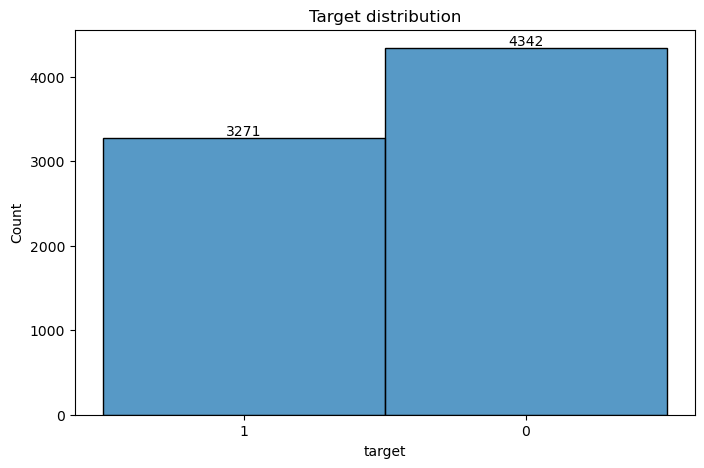

In [99]:
print('Target distribution (percentage):')
display(np.round(df_train['target'].value_counts(normalize=True)*100),2)
#---------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 5))
ax2 = sns.histplot(
    data = df_train['target'].astype(str),
#     x = 'target',
#     hue = 'target',
#     palette = 'colorblind',
    legend = False,
    ).set(
        title = 'Target distribution');
add_histogram_values(ax)

The data set is balanced

**Locations**

In [100]:
print('There are {} different locations in training set, with {} missing locations:'.format(
    len(df_train['location'].unique()),
    df_train['location'].isna().sum()))
df_train['location'].value_counts()

There are 3342 different locations in training set, with 2533 missing locations:


USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [101]:
print('There are {} different locations in test set, with {} missing locations:'.format(
    len(df_test['location'].unique()),
    df_test['location'].isna().sum()))
df_test['location'].value_counts()

There are 1603 different locations in test set, with 1105 missing locations:


New York                  38
USA                       37
Worldwide                 16
United States             15
London                    13
                          ..
Medford, NJ                1
Quezon City                1
LanÌ¼s                     1
USA,Washington,Seattle     1
Brussels, Belgium          1
Name: location, Length: 1602, dtype: int64

**Keywords**

In [102]:
print('There are {} different keywords in training set, with {} missing keywords:'.format(
    len(df_train['keyword'].unique()),
    df_train['keyword'].isna().sum()))
df_train['keyword'].value_counts()

There are 222 different keywords in training set, with 61 missing keywords:


fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [103]:
print('There are {} different keywords in test set, with {} missing keywords:'.format(
    len(df_test['keyword'].unique()),
    df_test['keyword'].isna().sum()))
df_test['keyword'].value_counts()

There are 222 different keywords in test set, with 26 missing keywords:


deluged               23
demolished            22
rubble                22
first%20responders    21
seismic               21
                      ..
threat                 5
fatalities             5
forest%20fire          5
inundation             4
epicentre              1
Name: keyword, Length: 221, dtype: int64

**¿Are all locations from test set also in training set?**


In [104]:
print('Locations in test set not found in train set:')
s = set(df_test['location']) 
s1 = s - set(df_train['location'])
print('There are {} locations in test set not found in train set. This means {:.0%} of the test set locations are not in train set'.format(len(s1),len(s1)/len(s)))
print('\nlist of such locations:')
print(s1)

Locations in test set not found in train set:
There are 1180 locations in test set not found in train set. This means 74% of the test set locations are not in train set

list of such locations:
{'Dallas', 'Calgary ', 'Fredericksburg, VA', 'Greater Vancouver, British Columbia', '121 N La Salle St, Suite 500', "ZIKKO'S HQ", '301|804', 'Citizen of the World', 'FL.CO.HI.NJ', 'finland ', 'The Court of Public Opinion.', 'Quezon City, National Capital Region', 'Nepal', '65 Skelmersdale Lane', 'Hutchinson, MN', 'Outer Rim', 'Surrey, BC', 'Sunny Florida', 'Lake Hefner Bike Trail', 'Plymouth, England', '@rejxctedmgc is my Harry?', 'mombasa', 'Herbville', 'North Coast of O-H-I-O', 'Louisiana the real La', 'Elko, Nevada', 'Kill Devil Hills', 'A glass case of emotions', 'England UK', 'Wheeler,Wis.', 'Saint Andrews, Scotland', 'Lakerland', 'High Desert', '#RoshanPakistan', 'Phuket', 'toronto \x89Û¢ unicorn island ', 'Somewhere on the Earth', 'tacompton, washington ', 'Halifax, Nova Scotia, Canada', 

**¿Are all keywords from test set also in training set?**

In [105]:
print('Keywords in test set not found in train set:')
s =  set(df_test['keyword'])
s1 = s- set(df_train['keyword'])
print('There are {} keywords in test set not found in train set. This means {:.0%} of the test set keywords are not in train set'.format(len(s1),len(s1)/len(s)))

print('\nlist of such keywords:')
print(s1)


Keywords in test set not found in train set:
There are 0 keywords in test set not found in train set. This means 0% of the test set keywords are not in train set

list of such keywords:
set()


**Distributions**

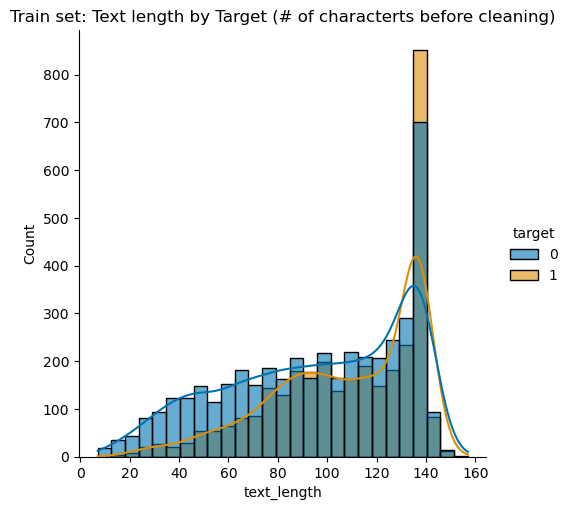

In [106]:
df_train['text_length'] = df_train['text'].apply(len)
df_test['text_length'] = df_test['text'].apply(len)

# fig, ax = plt.subplots(figsize=(8, 5))
ax2 = sns.displot(
    data = df_train,
    x = 'text_length',
    hue = 'target',
    palette = 'colorblind',
    kde = True,
    alpha = 0.6,
    legend = True,
    ).set(
        title = 'Train set: Text length by Target (# of characterts before cleaning)');


In [107]:
df_train.describe()

id      target  text_length
count   7613.000000  7613.00000  7613.000000
mean    5441.934848     0.42966   101.037436
std     3137.116090     0.49506    33.781325
min        1.000000     0.00000     7.000000
25%     2734.000000     0.00000    78.000000
50%     5408.000000     0.00000   107.000000
75%     8146.000000     1.00000   133.000000
max    10873.000000     1.00000   157.000000

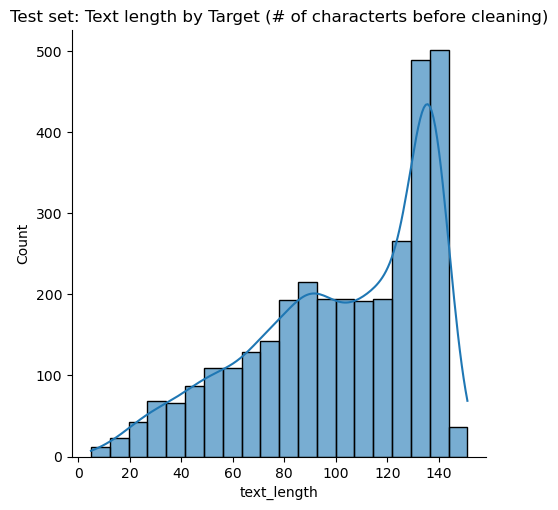

In [108]:
ax2 = sns.displot(
    data = df_test,
    x = 'text_length',
#     hue = 'target',
#     palette = 'colorblind',
    kde = True,
    alpha = 0.6,
    legend = True,
    ).set(
        title = 'Test set: Text length by Target (# of characterts before cleaning)');


In [109]:
df_test.describe()

id  text_length
count   3263.000000  3263.000000
mean    5427.152927   102.108183
std     3146.427221    33.972158
min        0.000000     5.000000
25%     2683.000000    78.000000
50%     5500.000000   109.000000
75%     8176.000000   134.000000
max    10875.000000   151.000000

**¿Is location or keyword correlated with target?**

Let us first replace unknown locations and keywords with "unknown". 

Next, let us see if knowing the location or keyword gives us information about the target. We do this by examining the conditional probability p(target|location) or p(target|keyword) for the top  values. From the histograms, we expect to have similar bar heights for target=0 and target=1 if there is no correlation.

In [110]:
# Check if 'unknown' is already in dataframe
print('Is the word "unknown" already a location?:','unknown' in set(df_train['location']))
print('Is the word "unknown" already a keyword?:','unknown' in set(df_train['keyword']))

Is the word "unknown" already a location?: False
Is the word "unknown" already a keyword?: False


In [111]:
def impute_unknown(df):
    df['location'].fillna('unknown',inplace = True)
    df['keyword'].fillna('unknown',inplace = True)
impute_unknown(df_train)
impute_unknown(df_test)
print('Imputing the word "unkown" has been imputed for NaNs in location and kewyword columns')

Imputing the word "unkown" has been imputed for NaNs in location and kewyword columns


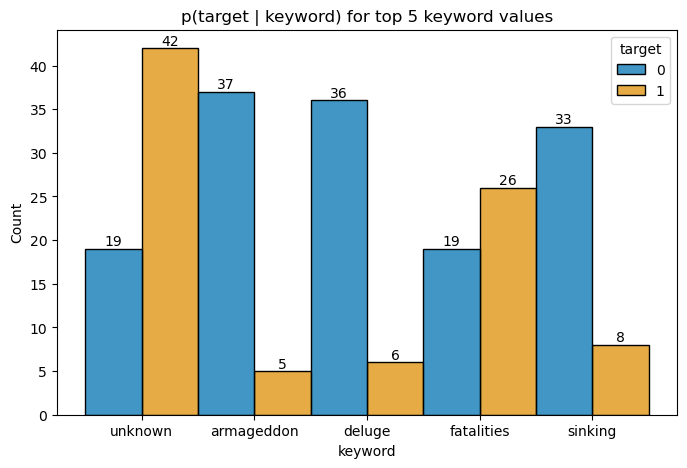

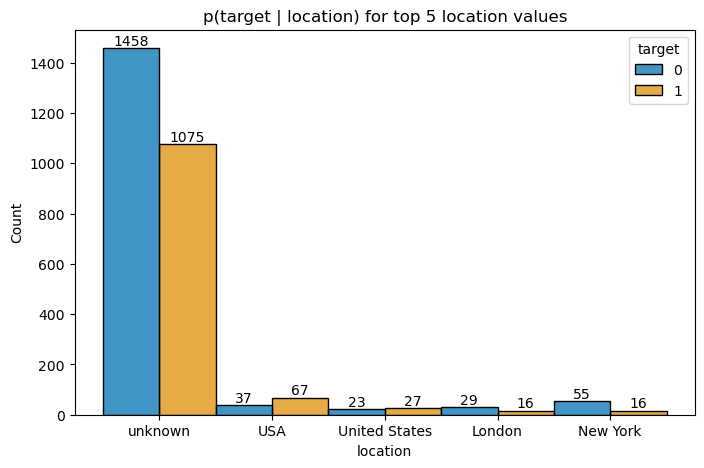

In [112]:
def hist_plot_top_vals(df,col_top,col_hue='target',ntop=5):
    top_n_vals = df[col_top].value_counts()[0:ntop].index
    df_top = df[df[col_top].isin(top_n_vals)]
    fig, ax = plt.subplots(figsize=(8, 5))
    title = 'p({} | {}) for top {} {} values'.format(
        col_hue, col_top, ntop, col_top)
    ax2 = sns.histplot(
        data = df_top,
        x = col_top,
        hue = col_hue,
        palette = 'colorblind',
        legend = True,
        multiple = 'dodge',
        ).set(
            title = title);
    add_histogram_values(ax)
#---------------------------------------------------------------------------------------------------
hist_plot_top_vals(df_train,'keyword')
hist_plot_top_vals(df_train,'location')

**Conclusions from data inspection**
* There are >7000 samples to train from
* Without precprocessing text, we have from 5 to 157 characters. Our model should be able to work with a variable number of inputs.

**Main words per category**

In [113]:
from wordcloud import WordCloud

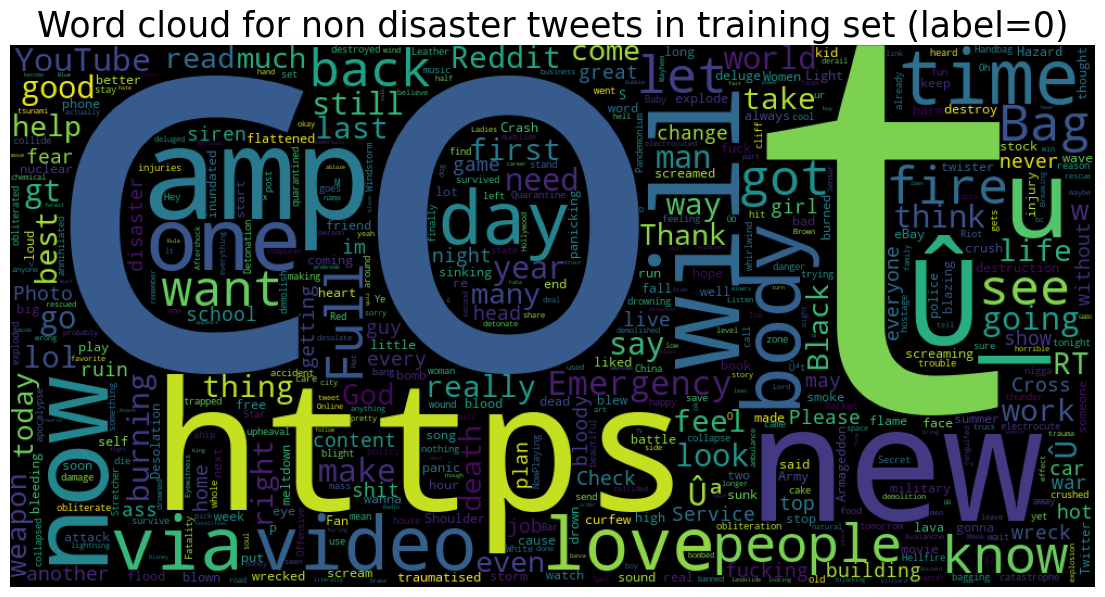

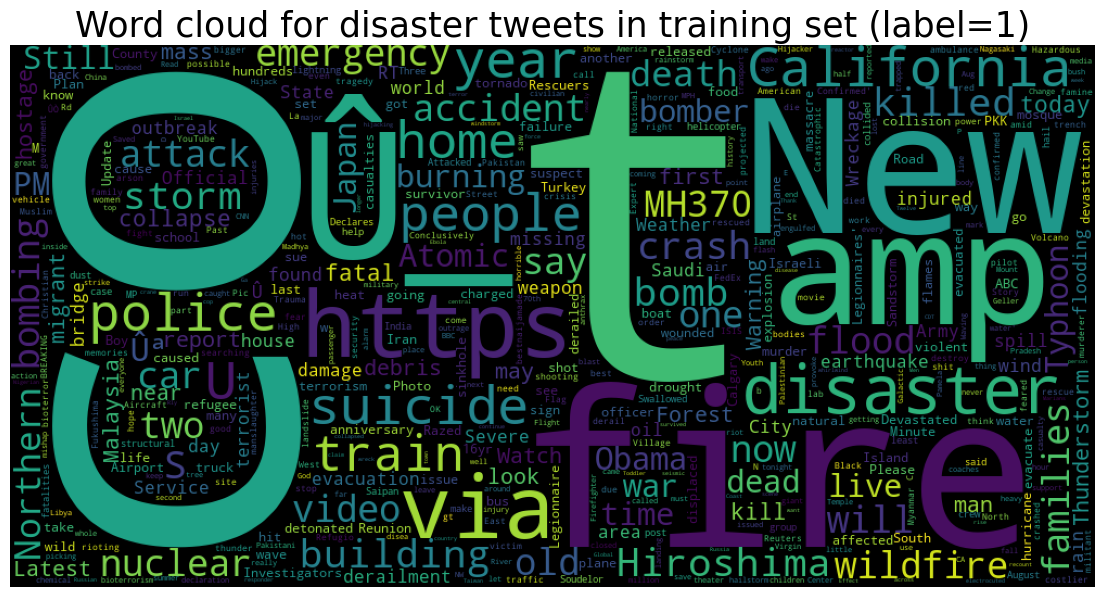

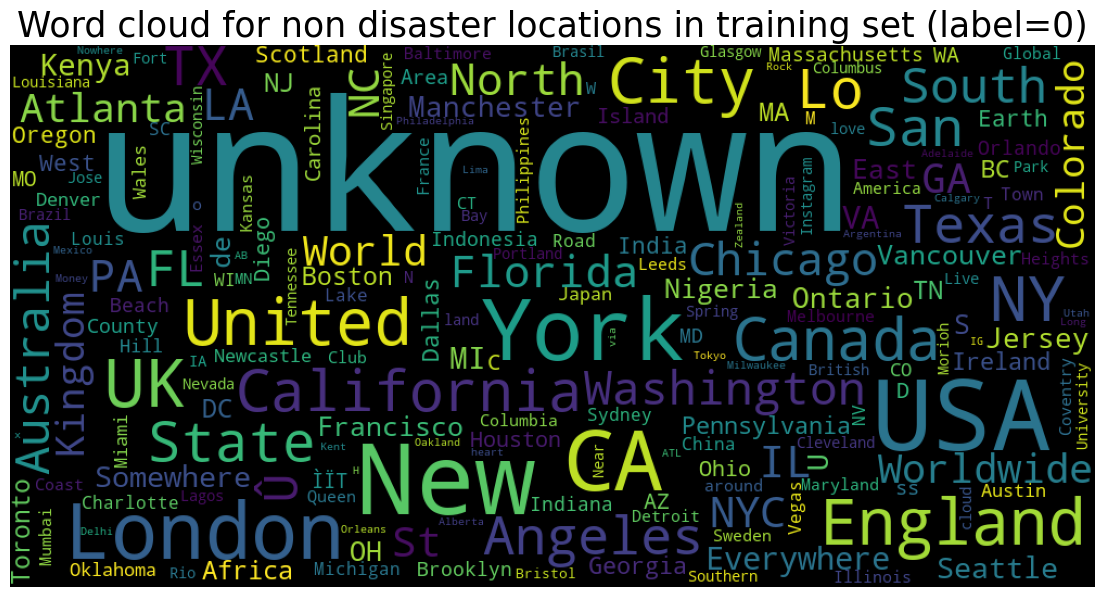

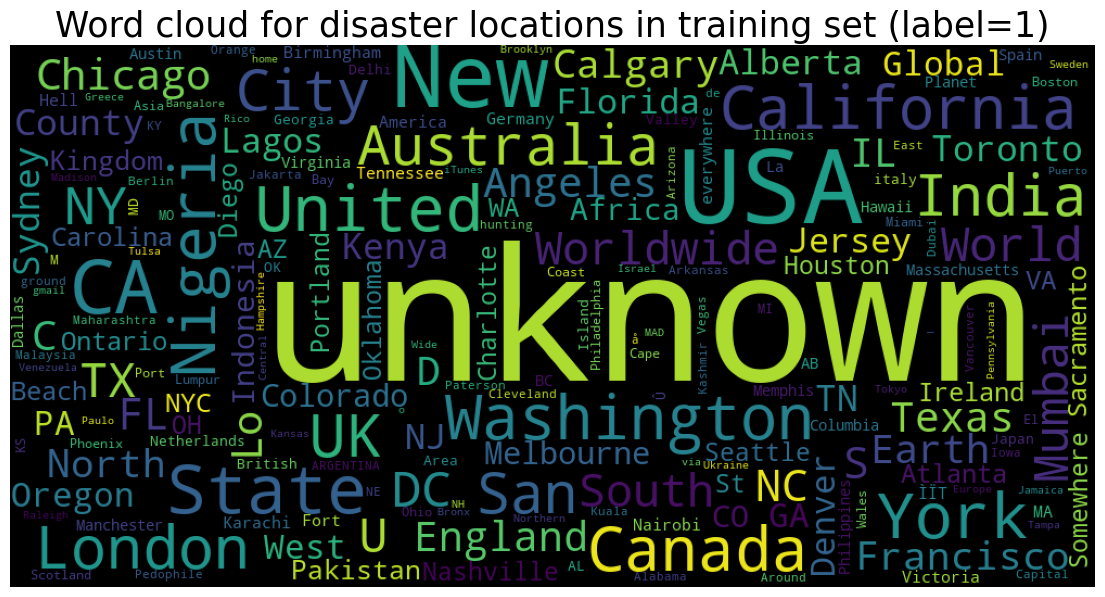

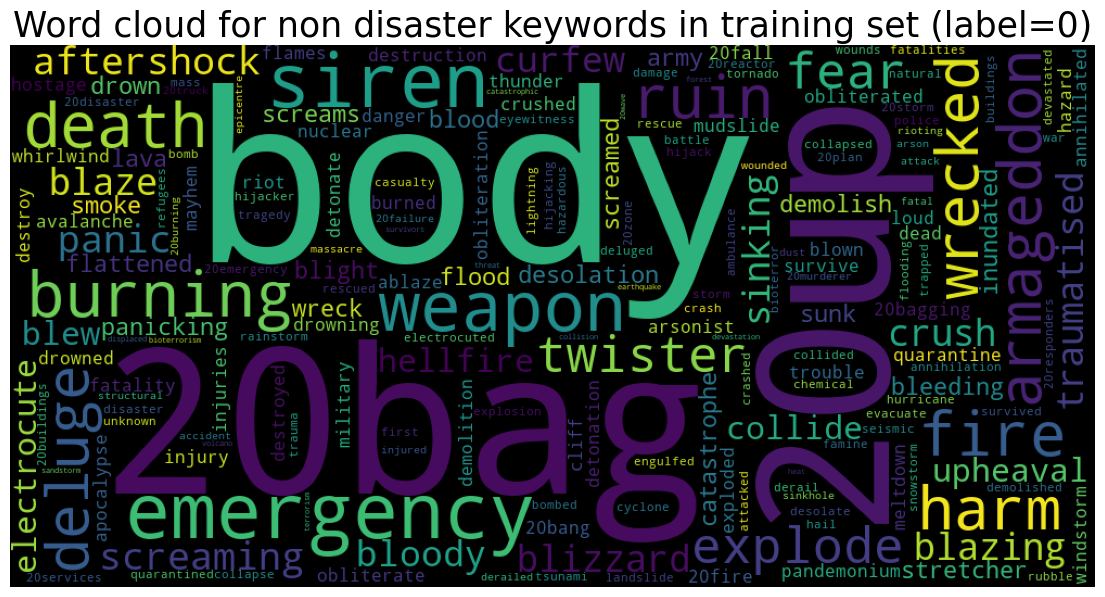

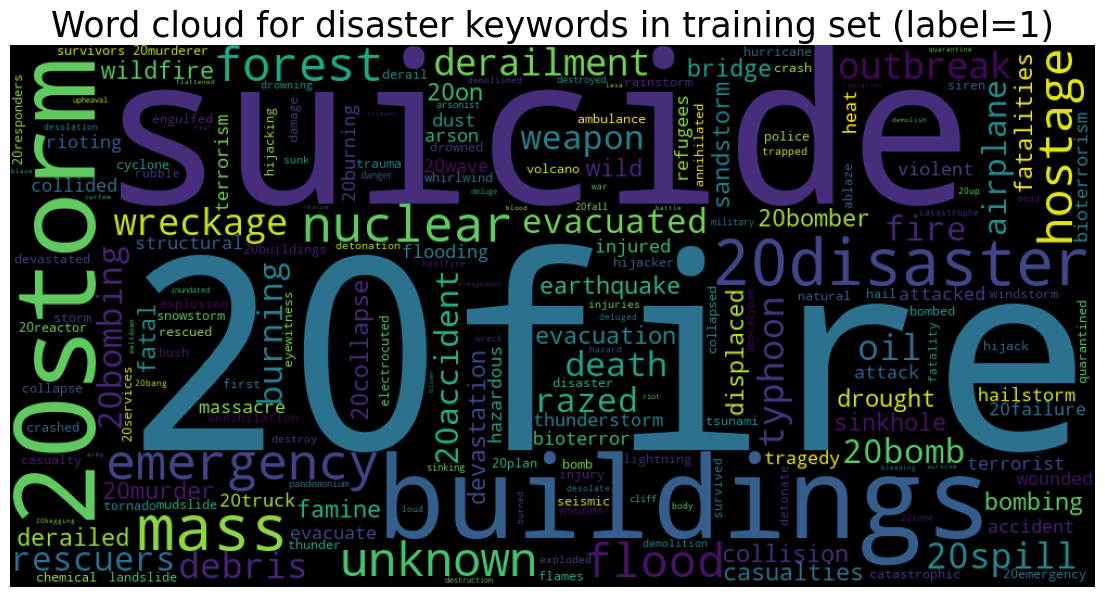

In [114]:
def plot_word_cloud(df,colname,target_filter=None,title='word could',num_words=500):
    if target_filter is not None:
        texts = df.loc[df['target']==target_filter,colname]
    else:
        texts = df[colname]
        
    one_text = " ".join(tweet for tweet in texts)
    wc = WordCloud(max_words = num_words , width = 1000 , height = 500,
              collocations=False).generate(one_text)
    plt.figure(figsize = (14,14))
    plt.axis("off")
    plt.imshow(wc)
    plt.title(title,fontsize=25)
plot_word_cloud(df_train,'text',0,'Word cloud for non disaster tweets in training set (label=0)')
plot_word_cloud(df_train,'text',1,'Word cloud for disaster tweets in training set (label=1)')
plot_word_cloud(df_train,'location',0,'Word cloud for non disaster locations in training set (label=0)',200)
plot_word_cloud(df_train,'location',1,'Word cloud for disaster locations in training set (label=1)',200)
plot_word_cloud(df_train,'keyword',0,'Word cloud for non disaster keywords in training set (label=0)',200)
plot_word_cloud(df_train,'keyword',1,'Word cloud for disaster keywords in training set (label=1)',200)

<a id='section3.2'></a>

## 3.2 Clean text data

**Clean Tweets**

In order to clean tweets I have adapted the original [Ruby code for text cleaning](https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb) as much as I could. Some parts I modified were:
* [Find user name with regex](https://stackoverflow.com/questions/2304632/regex-for-twitter-usernamehttps://stackoverflow.com/questions/2304632/regex-for-twitter-username)
* [Find URL](https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python)

The cleaning procedure for text involves regex expressios for dealing with:
* URLs
* User names
* Hashtags
* Emojis,
* Words in capital letters.


In [115]:
import re

In [116]:
def clean_text(text):
    """Apply a list of regex replacements to clean tweets"""
    
    def hashtag_sub(hashtag):
        """Clean hashtags"""
        hashtag_body = hashtag.group(1) # remove the "#" from string
        if hashtag_body.isupper():
            # Hashtag is all uppercase
            result = "<HASHTAG> "+ hashtag_body + " <ALLCAPS>"
        else:
            # Split hashtag on uppercase letters
            result = "<HASHTAG> "+ ' '.join(re.split(r'(?=[A-Z])', hashtag_body))
            result = re.sub('\s{2,}',' ',result) # remove double whitespaces
        return result
    
    # Parts of text smileys
    eyes = "[8:=;]"
    nose = "['`\-]?"     
    
    replacements = [
    ("(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*","<URL>"), # Replace URL
    ("/"," / "), # Force splitting words appended with slashes (once we tokenized the URLs, of course)
    ("(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)", "<USER>"), # Replace User name
    (rf"(?i){eyes}{nose}[)d]+|[)d]+{nose}{eyes}", "<SMILE>"), # Replace ':)' and alike
    (rf"(?i){eyes}{nose}p+", "<LOLFACE>"), # Replace ':P' and alike
    (rf"{eyes}{nose}\(+|\)+{nose}{eyes}", "<SADFACE>"), # Replace ':(' and alike
    (rf"{eyes}{nose}[\/|l*]", "<NEUTRALFACE>"), # not sure if this is working
    ("<3","<HEART>"), # replace heart emoji <3
    ("[-+]?[.\d]*[\d]+[:,.\d]*", " <NUMBER> "), #" Replace numbers"
    (r'#(\w+)',hashtag_sub), # Detect and split hashtags
    ("([!?.]){2,}",r"\1 <REPEAT>"),  # Mark punctuation repetitions (eg. "!!!" => "! <REPEAT>"
    (r"\b(\S*?)(.)\2{2,}\b",r"\1\2 <ELONG>"), # Mark elongated words (eg. "wayyyy" => "way <ELONG>"
    (r"(?<!\<)(\b[A-Z]{2,})",lambda m: m[0].lower() + ' <ALLCAPS>') # Detect words in capital letters that do not start with "<" (modified)
    ]
    for old, new in replacements:
        text = re.sub(old, new, text)
    return text

added_tags = ['<URL>',
              '<USER>',
              '<SMILE>',
              '<LOLFACE>',
              '<SADFACE>',
              '<NEUTRALFACE>',
              '<NUMBER>',
              '<HASHTAG>',
              '<ALLCAPS>',
              '<REPEAT>',
              '<ELONG>']

# Show how it words with random samples
print('-'*60,'\n   Random examples of tweets before and after cleaning:\n','-'*60)
for id in np.random.choice(len(df_train), size=10, replace=False):
    text = df_train['text'][id]
    cl = clean_text(text)
    if cl is not text:
        print(text,'\n => ', clean_text(text))

------------------------------------------------------------ 
   Random examples of tweets before and after cleaning:
 ------------------------------------------------------------
Season 3 of New Girl was such a emotional train wreck I just wanted to cry laugh and eat a lot of ice cream 
 =>  Season  <NUMBER>  of New Girl was such a emotional train wreck I just wanted to cry laugh and eat a lot of ice cream
That triumphant moment when you cook up two eggs over easy with no yolk casualties ?? http://t.co/fQJ5Aga1pd 
 =>  That triumphant moment when you cook up two eggs over easy with no yolk casualties ? <REPEAT> <URL>
@AdamNibloe Arrest report: Affiliation with Terrorism 
 =>  <USER> Arrest report: Affiliation with Terrorism
Upheaval high note for bush opera http://t.co/aWPU0gaE0b #Sydney #News #Aus 
 =>  Upheaval high note for bush opera <URL> <HASHTAG> Sydney <HASHTAG> News <HASHTAG> Aus
16yr old PKK suicide bomber who detonated bomb in Turkey Army trench released http://t.co/mMkLapX

In [117]:
# Apply text cleaning function to df_train and df_test
df_train["clean_text"] = df_train["text"].apply(clean_text)
df_test["clean_text"] = df_test["text"].apply(clean_text)

<a id='section3.3'></a>

## 3.3 Tokenize words

The use of keras Tokenizer and word glove word embeddings used here is inspired by [this work](https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470). The main differences are:
* We will use glove vectors trained on twitter. A similar cleaning method was implemented for consistency.
* We will predicta binary output, not the next word
* The sequence of words taken as input is sometimes too short, se we should be able to pass blank words.
* When training the tokenizer, let us add the word '\<blank>' to the vocabulary.

We will use Keras Tokenizer to split words. Each word will be mapped to an integer value in the `word_idx` dictionary (the reverse mapping is available as `idx_word`). The RNN will be fed with a sequence of integers representing words. Suppose we choose 

In [118]:
from keras.preprocessing.text import Tokenizer

def preprocess(df,tokenizer):
    """ Tokenize clean_text column in df """
    df['sequences'] = tokenizer.texts_to_sequences(df['clean_text'])
    df['seq_len'] = df['sequences'].apply(len)


# Create tokenizer
tokenizer = Tokenizer(num_words=None,
                     filters = '\t\n', # These are included in our embedding dict: '#$%&/()*+-<>=[\\]^_}`{|}'
                     lower = True,
                     split = ' ')
# Extract text to train tokenizer
tokenizer_train_strings = df_train['clean_text'].to_list()
tokenizer_train_strings.append('<blank>') # add this word to handle short sequences

# Fit tokenizer
tokenizer.fit_on_texts(tokenizer_train_strings);

# Get mappings of integers to wotds and reb
idx_word = tokenizer.index_word
word_idx = {word:idx for idx, word in idx_word.items()}

num_words = len(idx_word) + 1

# Apply tokenizer to transform data
preprocess(df_train,tokenizer)
preprocess(df_test,tokenizer)

# Show some results
print('-'*70,'\n Here are some random examples of tokenized tweets as integer lists:\n','-'*70)
for id in np.random.choice(len(df_train), size=10, replace=False):
    print(df_train['clean_text'][id])
    print(' =>',df_train['sequences'][id])

# Show stats
print('\n'*3,'Stats for training data:')
display(df_train.describe())
print('\nStats for test data:')
display(df_test.describe())
print('\nAfter tokenizing, {} different words were found in training data'.format(num_words))

---------------------------------------------------------------------- 
 Here are some random examples of tokenized tweets as integer lists:
 ----------------------------------------------------------------------
jax <ALLCAPS> issues Hazardous Weather Outlook (hwo <ALLCAPS>) <URL>
 => [6531, 1, 542, 431, 258, 1696, 1863, 286, 2]
Wow-the name <HASHTAG> Legionnaires Disease comes from an outbreak of pneumonia at the <USER> convention in Philly in  <NUMBER> - <NUMBER>  died from it.
 => [15547, 873, 4, 3265, 1193, 964, 27, 48, 372, 10, 15548, 22, 3, 6, 15549, 8, 3068, 8, 5, 17, 5, 608, 27, 335]
I entered to <HASHTAG> win the entire <ALLCAPS> set of butterLONDON Lip Crayons via <USER>. - Go enter! <HASHTAG> bbloggers <URL>
 => [13, 3053, 9, 4, 843, 3, 850, 1, 267, 10, 8458, 3017, 8459, 58, 1271, 17, 116, 8460, 4, 8461, 2]
<USER> I am <ALLCAPS> being <ALLCAPS> subjected <ALLCAPS> to <ALLCAPS> unwarranted <ALLCAPS> sexual <ALLCAPS> conversation <ALLCAPS>.
 => [6, 13, 155, 1, 127, 1, 14778, 1

id      target  text_length      seq_len
count   7613.000000  7613.00000  7613.000000  7613.000000
mean    5441.934848     0.42966   101.037436    16.764613
std     3137.116090     0.49506    33.781325     6.745955
min        1.000000     0.00000     7.000000     1.000000
25%     2734.000000     0.00000    78.000000    12.000000
50%     5408.000000     0.00000   107.000000    17.000000
75%     8146.000000     1.00000   133.000000    22.000000
max    10873.000000     1.00000   157.000000    51.000000


Stats for test data:


id  text_length      seq_len
count   3263.000000  3263.000000  3263.000000
mean    5427.152927   102.108183    15.323016
std     3146.427221    33.972158     6.550926
min        0.000000     5.000000     0.000000
25%     2683.000000    78.000000    11.000000
50%     5500.000000   109.000000    15.000000
75%     8176.000000   134.000000    20.000000
max    10875.000000   151.000000    55.000000


After tokenizing, 18829 different words were found in training data


In [119]:
blank_id = word_idx['<blank>']
print('Missing words will be mapped to id: ',blank_id,'<blank>')
num_words+=1 # update number of words

Missing words will be mapped to id:  18828 <blank>


**Remarks**
* For some tokenizations, the tweets may become empty. We should be able to produce a sequence of blank words.

In [120]:
print('Most commong words:')
[print(id+1,idx_word[id+1]) for id in range(10)];

Most commong words:
1 <allcaps>
2 <url>
3 the
4 <hashtag>
5 <number>
6 <user>
7 a
8 in
9 to
10 of


In [121]:
max_words_per_text = df_train['seq_len'].max()
print('Let us try a model with a maximum number of {} words'.format(max_words_per_text))

Let us try a model with a maximum number of 51 words


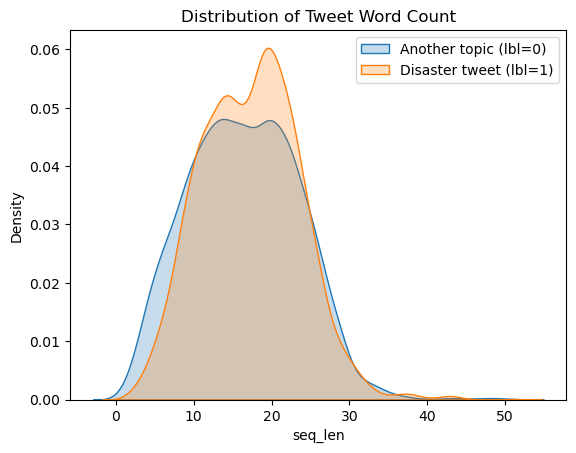

In [122]:
# create graphs
sns.kdeplot(df_train['seq_len'][df_train['target'] == 0], fill=True, label = 'Another topic (lbl=0)');
sns.kdeplot(df_train['seq_len'][df_train['target'] == 1], fill=True, label = 'Disaster tweet (lbl=1)');
# set title and plot
plt.title('Distribution of Tweet Word Count')
plt.legend();
plt.show()


Because the method we used for tokenizing converts the text to lowercase, let us update the list of modify the list of added tags. Also, let us include the word \<blank> in our list of added tags

In [123]:
added_tags = [tag.lower() for tag in added_tags]
if '<blank>' not in added_tags:
    added_tags.append('<blank>')
added_tags

['<url>',
 '<user>',
 '<smile>',
 '<lolface>',
 '<sadface>',
 '<neutralface>',
 '<number>',
 '<hashtag>',
 '<allcaps>',
 '<repeat>',
 '<elong>',
 '<blank>']

<a id='section3.4'></a>

## 3.4 Use Glove to get a pretrained embedding matrix for tweets

The University of Stanford had published [glove word embeddings trained on 2B tweets](https://nlp.stanford.edu/projects/glove/).
We will use those word embeddings in our RNN model.

Notice that a similar cleaning procedure has been implemented here, where tags such as "\<USER>" are added.

In [124]:
# Load word embeddings from Stanford glove trained on twitter data
embeddings_filename = '/kaggle/input/glove-twitter-pickles-27b-25d-50d-100d-200d/glove.twitter.27B.100d.pkl'
print('Loading word embeddings from Glovec trained on twitter data')
with open(embeddings_filename, 'rb') as f:
    embeddings = pickle.load(f)
embed_dim = len(embeddings['the'])    
print('{} word embedding vectors of dimension {} were loaded'.format(len(embeddings),embed_dim))

Loading word embeddings from Glovec trained on twitter data
1193514 word embedding vectors of dimension 100 were loaded


**Check tags**

Let us now verify that the following special tags we included during text cleaning are also available in the word embeddings dictionary.

In [125]:
# Verify that the following words are included in the word embeddings dictionary:
{tag.lower(): embeddings.get(tag.lower(),'not found') for tag in added_tags}

{'<url>': array([ 0.33292  , -0.54203  , -0.11322  , -0.27659  , -0.026186 ,
        -0.82087  , -0.21403  , -0.16494  ,  0.25512  ,  0.73279  ,
        -0.28273  ,  0.30562  , -2.3428   ,  0.57922  ,  0.28763  ,
        -0.99739  , -0.092065 , -0.38625  , -0.056712 ,  0.22435  ,
        -0.30217  ,  0.092644 ,  0.23267  ,  0.053841 ,  0.5248   ,
        -1.4725   , -0.21217  ,  0.60497  ,  1.0452   ,  0.0067332,
        -0.50481  , -1.1028   , -1.1451   ,  0.3235   ,  0.89579  ,
        -0.42413  , -0.17208  , -0.086374 , -0.62347  , -0.25032  ,
        -0.91658  ,  0.17972  , -0.015353 ,  0.52888  ,  1.3924   ,
         0.34129  ,  0.36661  ,  0.052747 , -0.3025   , -1.0406   ,
        -0.31652  , -1.1544   , -0.42162  , -0.17128  ,  0.89121  ,
         0.19002  ,  0.080897 ,  0.41373  , -0.094438 ,  0.18039  ,
         0.54055  , -0.98818  , -0.23105  , -0.36734  ,  0.21701  ,
        -0.27166  , -0.20397  ,  0.48816  ,  0.28361  ,  0.078591 ,
         0.6951   , -0.18313  ,  0.7354

**Handle blanks**

We can see that the word embeddings taken from twitter already contain all the tags introduced during text cleaning. The tag "\<blank>" was added here to fill the slots of the RNN where text is too short. We have two options at this point:
1. Map it to a vector of zeros
2. Map it to a vector of a related word such as blank or empty

Notice that unrecognized words in our model will be passed to a mask that will assign the vector 0 to them. However, an unrecognized word is different from an empty slot, so let us distinguish them by using the second approach here.

In [126]:
embeddings['<blank>'] = embeddings['empty']

In [127]:
# Build a matrix to store word embeddings
embedding_matrix = np.zeros((num_words,embed_dim))
print('The embedding matrix has shape {}'.format(embedding_matrix.shape))
for i, word in enumerate(word_idx.keys()):
    vector = embeddings.get(word,None)
    if vector is not None:
        embedding_matrix[i+1,:] = vector

The embedding matrix has shape (18830, 100)


<a id='section3.5'></a>

In [128]:
df_train_sub, df_cv_sub = train_test_split(df_train, test_size=0.2, stratify=df_train['target'])
print('The training data set was split into {} entries for training and {} entries for cross validation'
      .format(len(df_train_sub), len(df_cv_sub)))


The training data set was split into 6090 entries for training and 1523 entries for cross validation


<a id='section4'></a>

# 4. Models
Let us start by finding the expected accuracy of a very naive model: predicting the maximum category always.

In [129]:
from sklearn import metrics

**Targets**

In [130]:
y_train = df_train_sub['target']
y_cv = df_cv_sub['target']

**Baseline: predict most frequent**

In [131]:
most_frequent = y_train.value_counts().index[0]
y_pred_cv = df_cv_sub['target']*0 + most_frequent
print(y_pred_cv)

361     0
6224    0
6349    0
2556    0
5414    0
       ..
7364    0
7229    0
4651    0
2036    0
458     0
Name: target, Length: 1523, dtype: int64


In [132]:
def display_conf_max_and_acc(y_true,y_pred,model_name):
    acc = metrics.accuracy_score(y_true,y_pred)
    cm=metrics.confusion_matrix(y_true,y_pred);
    print('Cross validation accuracy of model `{}` is {:.2%}'.format(model_name,acc))
    metrics.ConfusionMatrixDisplay(cm).plot();
    return acc

Cross validation accuracy of model `Baseline - Predict most frequent category` is 57.06%


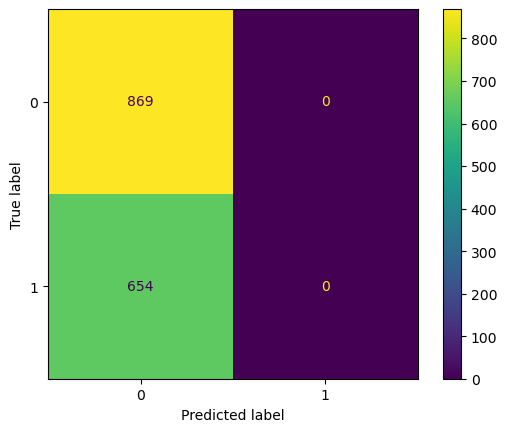

In [133]:
name = 'Baseline - Predict most frequent category'
acc = display_conf_max_and_acc(y_cv,y_pred_cv,name)

In [134]:
models = [] # All model results will be stored here

# Baseline model
model = {'model_name': name,
    'cv_acc': acc}

models.append(model)
print("Model: {}\nCross Val accuracy: {:.2%}".format(model['model_name'],model['cv_acc']))

Model: Baseline - Predict most frequent category
Cross Val accuracy: 57.06%


<a id='section4.1'></a>

## 4.1 Basic model using keyword and location only

Let us use a tree based model to predict target without using the text column. We would normally use one-hot encoding, but with trees [one can directly use ordinal encoding](https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769)

**Create Gradient boosting model**

In [135]:
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier as GB
from sklearn.model_selection import GridSearchCV

In [136]:
cols_to_encode = ['keyword','location']
ct = ColumnTransformer(
    [("ordinal_encoder",
      preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1),
      cols_to_encode)],
#     remainder="passthrough"
)
ct = ct.fit(df_train[cols_to_encode])  


X_train_gb = ct.transform(df_train_sub[cols_to_encode])
X_cv_gb = ct.transform(df_cv_sub[cols_to_encode])
X_test_gb = ct.transform(df_test[cols_to_encode])

In [137]:

# np.concatenate([X_train_gb,X_cv_gb]).shape
# # np.concatenate([y_train,y_cv])


In [138]:
# Train and use hyperarameter optimization
# Note: we want to use the same cross validation split here and in the Keras model,
# and for this we use a PredefinedSplit with one fold.
from sklearn.model_selection import PredefinedSplit

clf = GB(n_estimators=200,
         learning_rate=1.5,
         max_depth=1)

param_grid = {'n_estimators': [50,150,300],
              'learning_rate': [0.05, 0.1, 0.2],
             'max_depth':[2,3,5]}
print('X_train_gb:',X_train_gb.shape,type(X_train_gb))
print('X_cv_gb:',X_train_gb.shape,type(X_cv_gb))
print('y_train:',y_train.shape,type(y_train))
print('y_cv:',y_cv.shape,type(y_cv))
xx = np.concatenate([X_train_gb,X_cv_gb])
yy = np.concatenate([y_train,y_cv])
test_fold =np.zeros_like(yy);
test_fold[0:X_train_gb.shape[0]]=-1
hyper_search = GridSearchCV(clf,
                            param_grid,
                            cv = PredefinedSplit(test_fold),
                            refit = True,
                            verbose = 3)
# hyper_search.fit(X_train_gb,y_train)

hyper_search.fit(xx,yy)



X_train_gb: (6090, 2) <class 'numpy.ndarray'>
X_cv_gb: (6090, 2) <class 'numpy.ndarray'>
y_train: (6090,) <class 'pandas.core.series.Series'>
y_cv: (1523,) <class 'pandas.core.series.Series'>
Fitting 1 folds for each of 27 candidates, totalling 27 fits
[CV 1/1] END learning_rate=0.05, max_depth=2, n_estimators=50;, score=0.605 total time=   0.1s
[CV 1/1] END learning_rate=0.05, max_depth=2, n_estimators=150;, score=0.632 total time=   0.4s
[CV 1/1] END learning_rate=0.05, max_depth=2, n_estimators=300;, score=0.652 total time=   0.8s
[CV 1/1] END learning_rate=0.05, max_depth=3, n_estimators=50;, score=0.625 total time=   0.2s
[CV 1/1] END learning_rate=0.05, max_depth=3, n_estimators=150;, score=0.656 total time=   0.6s
[CV 1/1] END learning_rate=0.05, max_depth=3, n_estimators=300;, score=0.689 total time=   1.1s
[CV 1/1] END learning_rate=0.05, max_depth=5, n_estimators=50;, score=0.655 total time=   0.3s
[CV 1/1] END learning_rate=0.05, max_depth=5, n_estimators=150;, score=0.710 t

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=GradientBoostingClassifier(learning_rate=1.5,
                                                  max_depth=1,
                                                  n_estimators=200),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [2, 3, 5],
                         'n_estimators': [50, 150, 300]},
             verbose=3)

In [139]:
print('Best hyperparameters:\n',hyper_search.best_params_)
print('Best score:\n',hyper_search.best_score_)

Best hyperparameters:
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300}
Best score:
 0.7156927117531189


In [140]:
clf = hyper_search.best_estimator_
print(clf)

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, n_estimators=300)


Cross validation accuracy of model `Gradient Boosting using keyword and location only` is 77.41%


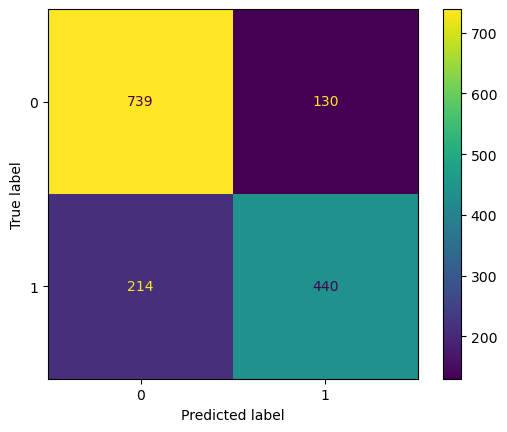

In [141]:
# Results
y_pred_cv = clf.predict(X_cv_gb)
name = 'Gradient Boosting using keyword and location only'
acc = display_conf_max_and_acc(y_cv,y_pred_cv,name)

In [142]:
# Simple gradient boosting model
model = {'model_name': name,
    'cv_acc': acc,
        'model': clf}

models.append(model)
print("Model: {}\nCross Val accuracy: {:.2%}".format(model['model_name'],model['cv_acc']))

Model: Gradient Boosting using keyword and location only
Cross Val accuracy: 77.41%


In [143]:
pd.DataFrame(models)

model_name    cv_acc  \
0          Baseline - Predict most frequent category  0.570584   
1  Gradient Boosting using keyword and location only  0.774130   

                                               model  
0                                                NaN  
1  ([DecisionTreeRegressor(criterion='friedman_ms...

<a id='section4.2'></a>

## 4.2 Recursive neural network model with one LSTM layer based on text only

**Prepare text input vector for RNNs as a sequence of integers based on tokenizer**

We will be using Glove word embeddings trained on twitter data. The RNN model will be fed with a sequence of integers representing words.
Instead of padding zeros, we will pad embeddings from a desired word to the left of the text sequence.

In [144]:
model_word_slots = max_words_per_text
print('The RNN model will be using {} words per text'.format(model_word_slots))

The RNN model will be using 51 words per text


In [145]:
# We could use pad_sequences from keras to pad zeros, but another approach is used here
def prepare_input_data_from_one_seq(seq:list,blank_id:int=0,desired_len:int=20):
    """
    Given a sequence of numbers, return a row of desired length padding blank_id on the left of seq
    """
    x = np.zeros(desired_len,dtype=np.int32)
    x.fill(blank_id)
    n = np.min([len(seq),desired_len])
    if n>0:
        x[-n:] = np.array(seq)[:n]
    return x
def prepare_input_data(df,blank_id, n_words):
    """ Compute X for our neural network model"""
    s = lambda row: prepare_input_data_from_one_seq(row,blank_id,n_words)
    return np.stack(df['sequences'].apply(s))

# Compute X from dataframes
X_train_rnn = prepare_input_data(df_train_sub,blank_id, model_word_slots)
X_cv_rnn = prepare_input_data(df_cv_sub,blank_id, model_word_slots)
X_test_rnn = prepare_input_data(df_test,blank_id, model_word_slots)
# Reshape labels into 2d 
y_train_rnn = y_train.values.reshape(-1,1)
y_cv_rnn = y_cv.values.reshape(-1,1)

print("Dimensions: \n Xtrain: {}\n y_train_rnn: {}".format(X_train_rnn.shape,y_train_rnn.shape))

Dimensions: 
 Xtrain: (6090, 51)
 y_train_rnn: (6090, 1)


In [146]:

np.random.randint(8)

3

In [147]:
print('Display random sample of sequence fed to model:')
k = np.random.randint(X_train_rnn.shape[0])
print('Original text:')
print(df_train_sub['text'].iloc[k])
print('Sequence as words:')
[idx_word[id] for id in X_train_rnn[k]]

Display random sample of sequence fed to model:
Original text:
Nothing to fear. It's all about taking risks.
Sequence as words:


['<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 '<blank>',
 'nothing',
 'to',
 'fear.',
 "it's",
 'all',
 'about',
 'taking',
 'risks.']

**Create RNN model with Keras Sequential API**

In [148]:
from keras import Sequential, layers, Input, Model
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.optimizers import Adam, Nadam

In [149]:
def create_rnn_model(name:str='my_rnn_model',
                     num_RNN_cell_layers:int=1,
                     dim_RNN_cell=32,
                     dim_dense_lyr = 16,
                    learning_rate = 5e-4,
                    dropout = 0.4,
                    rnn_cell_type = 'LSTM'):
    model = Sequential(name=name)
    model.add(layers.Embedding(input_dim = num_words, # number of words in vocabulary
                       input_length = model_word_slots, # number of words in input
                       output_dim = embed_dim, # glove vector length
                       weights = [embedding_matrix], # precomputed weights from glove
                       trainable = False,
                       mask_zero = True))
    # map unknowun values to 0
    model.add(layers.Masking(mask_value = 0.0)) 
    
    # Optional Intermediate RNN (LSTM or GRU) layers
    RNN_cell_types = {'LSTM':layers.LSTM,
                     'GRU': layers.GRU}
    rnn_cell = RNN_cell_types[rnn_cell_type]
    if num_RNN_cell_layers>1:
        for i in range(num_RNN_cell_layers-1):
            model.add(rnn_cell(dim_RNN_cell,
                           recurrent_dropout = dropout,
                           dropout = dropout,
                           return_sequences=True))
    # Last RNN cell layer
    model.add(rnn_cell(dim_RNN_cell))
    return_sequences=True

    # Fully connected layer
    model.add(layers.Dense(dim_dense_lyr, activation='relu'))

    # Dropout for regularization
    model.add(layers.Dropout(dropout))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid',name = 'output'))
    
    model.compile(
    optimizer=Nadam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

rnn_model1 = create_rnn_model('RNN_single_LSTM_cell_only_text',1,32,16)

rnn_model1.summary()

Model: "RNN_single_LSTM_cell_only_text"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 51, 100)           1883000   
                                                                 
 masking_2 (Masking)         (None, 51, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                17024     
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 1,900,569
Trainable pa

In [150]:
# Create callbacks
models_path = '../models'
model_save_path = os.path.join(models_path,rnn_model1.name+'.h5')
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(model_save_path, save_best_only=True, 
                             save_weights_only=False)]

In [151]:
print('Training {} model on texts only...\n'.format(rnn_model1.name))
history = rnn_model1.fit(X_train_rnn,  y_train_rnn, 
                    batch_size=64, epochs=150,
                    callbacks=callbacks,
                    validation_data=(X_cv_rnn, y_cv_rnn))
print('...Done')

Training RNN_single_LSTM_cell_only_text model on texts only...

Epoch 1/150
96/96 [==============================] - 9s 51ms/step - loss: 0.6124 - accuracy: 0.6706 - val_loss: 0.5291 - val_accuracy: 0.7485
Epoch 2/150
96/96 [==============================] - 3s 35ms/step - loss: 0.5178 - accuracy: 0.7649 - val_loss: 0.4879 - val_accuracy: 0.7814
Epoch 3/150
96/96 [==============================] - 3s 35ms/step - loss: 0.4900 - accuracy: 0.7852 - val_loss: 0.4952 - val_accuracy: 0.7728
Epoch 4/150
96/96 [==============================] - 3s 35ms/step - loss: 0.4793 - accuracy: 0.7923 - val_loss: 0.4700 - val_accuracy: 0.7899
Epoch 5/150
96/96 [==============================] - 3s 36ms/step - loss: 0.4655 - accuracy: 0.7972 - val_loss: 0.4671 - val_accuracy: 0.7846
Epoch 6/150
96/96 [==============================] - 3s 35ms/step - loss: 0.4610 - accuracy: 0.8046 - val_loss: 0.4534 - val_accuracy: 0.7919
Epoch 7/150
96/96 [==============================] - 3s 35ms/step - loss: 0.4470 - a

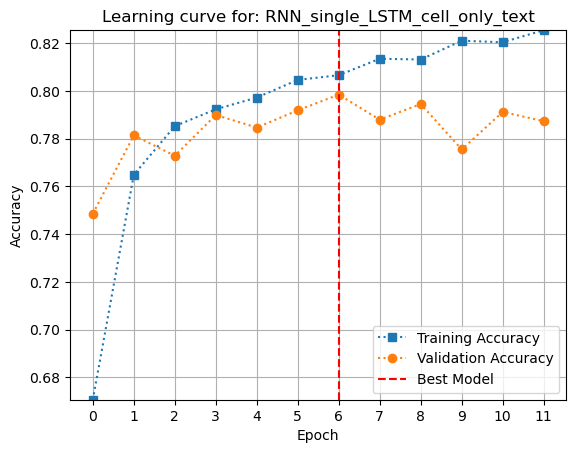

In [152]:
def plot_learning_curves(history,model_name):
    """
    Plots the training and validation loss over epochs from a Keras history object.
    """

    # Get training and validation loss values from the history object
    train_acc  = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    
    # Get number of epochs
    num_epochs = range(len(train_acc ))

    # Find epoch with highest validation accuracy
    best_epoch = val_acc.index(max(val_acc))

    # Plot the training and validation accuracy over epochs
    plt.plot(num_epochs, train_acc,':s', label='Training Accuracy')
    plt.plot(num_epochs, val_acc,':o', label='Validation Accuracy')
    plt.axvline(x=best_epoch, linestyle='--', color='r', label='Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([np.min(train_acc),np.max(train_acc)])
    plt.legend()
    plt.xticks(range(len(num_epochs)), [str(i) for i in num_epochs]) 
    plt.title('Learning curve for: ' + model_name)
    plt.grid()    
    plt.show()
plot_learning_curves(history,rnn_model1.name)

In [153]:
# Reload best model
rnn_model1 = load_model(model_save_path)

Computing model predictions...
48/48 [==============================] - 2s 9ms/step
Cross validation accuracy of model `RNN_single_LSTM_cell_only_text` is 79.84%


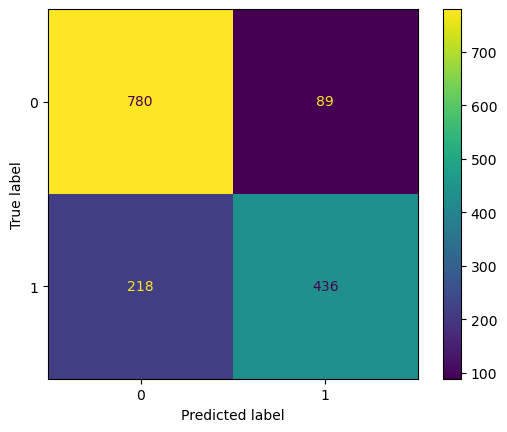

In [154]:
print('Computing model predictions...')
y_prob_cv = rnn_model1.predict(X_cv_rnn)
y_pred_cv = np.round(y_prob_cv)

acc = display_conf_max_and_acc(y_cv,y_pred_cv,rnn_model1.name)

In [155]:
# Recursive neural network LSTM model using text only
model = {'model_name': rnn_model1.name,
    'cv_acc': acc,
        'model': rnn_model1}

models.append(model)
print("Model: {}\nCross Val accuracy: {:.2%}".format(model['model_name'],model['cv_acc']))

Model: RNN_single_LSTM_cell_only_text
Cross Val accuracy: 79.84%


In [156]:
pd.DataFrame(models)

model_name    cv_acc  \
0          Baseline - Predict most frequent category  0.570584   
1  Gradient Boosting using keyword and location only  0.774130   
2                     RNN_single_LSTM_cell_only_text  0.798424   

                                               model  
0                                                NaN  
1  ([DecisionTreeRegressor(criterion='friedman_ms...  
2  <keras.engine.sequential.Sequential object at ...

<a id='section4.3'></a>

## 4.3 RNN model based on text only (hyperparameter optimization with LSTM and GRU)
Let us perform hyperaprameter optimization. We will optimize the number of stacked RNN layers and try both GRU and LSTM cells.

In [157]:
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner.tuners import Hyperband

In [158]:
# Define the hyperparameter search space
model_name = 'RNN_tuned_text_only2'

def build_model(hp):
    """
    Build model for keras tuner. 
    Remove comments to tune other hyperparameters (will take several hours)
    Some parts may be commented for shorter running times
    """
    num_RNN_cell_layers = hp.Int('num_RNN_cell_layers', 1, 3);
#     dim_RNN_cell = hp.Int('dim_RNN_cell', 16, 64);
#     dim_dense_lyr = hp.Int('dim_dense_lyr', 8, 32);
#     learning_rate = hp.Float('learning_rate', 1e-3, 5e-2, sampling='log');
    dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.2);
    rnn_cell_type = hp.Choice('rnn_cell_type', ['LSTM','GRU']);

    return create_rnn_model(model_name,
                            num_RNN_cell_layers=num_RNN_cell_layers,
#                             dim_RNN_cell=dim_RNN_cell,
#                             dim_dense_lyr=dim_dense_lyr,
#                             learning_rate=learning_rate,
                            dropout=dropout,
                            rnn_cell_type = rnn_cell_type)

# Create callbacks
models_path = '../hypertuning_models'
model_save_path = os.path.join(model_name+'.h5')
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(model_save_path, save_best_only=True, 
                             save_weights_only=False)]

# Create the tuner and search for the best hyperparameters
hp = HyperParameters();

tuner = Hyperband(
    build_model,
    hyperparameters=hp,
    objective='val_accuracy',
    hyperband_iterations=2,
    directory='Keras_Hypertuning',
    project_name='RNN_hypertune'
)

In [159]:
# Tune model hyperparameters using cross validation
tuner.search(X_train_rnn, y_train_rnn,
             epochs = 50,
             batch_size=64,
             validation_data=(X_cv_rnn, y_cv_rnn),
             callbacks=callbacks)

Trial 12 Complete [00h 00m 36s]
val_accuracy: 0.7721602320671082

Best val_accuracy So Far: 0.7839789986610413
Total elapsed time: 00h 03m 34s


In [160]:
# Create callbacks
models_path = '../models'
model_save_path = os.path.join(models_path,rnn_model1.name+'.h5')
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(model_save_path, save_best_only=True, 
                             save_weights_only=False)]

In [161]:
# Get top hyperparameters.
best_hp = tuner.get_best_hyperparameters()[0]
print("best hyperparameters:\n",best_hp.values)
# Build the model with the best hp.
rnn_model2 = build_model(best_hp)
rnn_model2.summary()
print('Training {} model on texts only...\n'.format(rnn_model2.name))
history = rnn_model2.fit(X_train_rnn,  y_train_rnn, 
                    batch_size=64, epochs=150,
                    callbacks=callbacks,
                    validation_data=(X_cv_rnn, y_cv_rnn))
print('Done')

best hyperparameters:
 {'num_RNN_cell_layers': 1, 'dropout': 0.4, 'rnn_cell_type': 'LSTM', 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 4, 'tuner/round': 0}
Model: "RNN_tuned_text_only2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 51, 100)           1883000   
                                                                 
 masking_1 (Masking)         (None, 51, 100)           0         
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 out

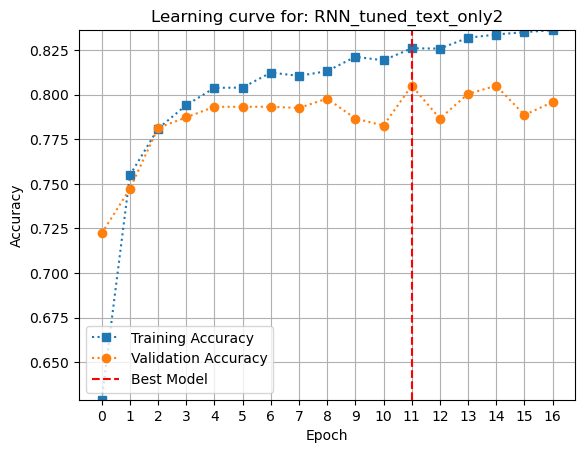

In [162]:
plot_learning_curves(history,rnn_model2.name)

In [163]:
# Reload best model
rnn_model2 = load_model(model_save_path)

In [164]:
# !rm -rf /kaggle/working/Keras_Hypertuning # Remove model (use this to restart keras tuner)

Computing model predictions...
48/48 [==============================] - 2s 10ms/step
Cross validation accuracy of model `RNN_tuned_text_only2` is 80.50%


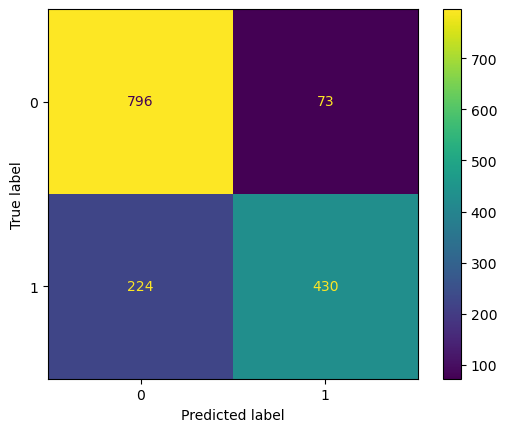

In [165]:
print('Computing model predictions...')
y_prob_cv = rnn_model2.predict(X_cv_rnn)
y_pred_cv = np.round(y_prob_cv)
acc = display_conf_max_and_acc(y_cv,y_pred_cv,rnn_model2.name)

In [166]:
# Recursive neural network LSTM model using text only
model = {'model_name': rnn_model2.name,
    'cv_acc': acc,
        'model': rnn_model2}
models.append(model)
print("Model: {}\nCross Val accuracy: {:.2%}".format(model['model_name'],model['cv_acc']))

Model: RNN_tuned_text_only2
Cross Val accuracy: 80.50%


In [167]:
pd.DataFrame(models)

model_name    cv_acc  \
0          Baseline - Predict most frequent category  0.570584   
1  Gradient Boosting using keyword and location only  0.774130   
2                     RNN_single_LSTM_cell_only_text  0.798424   
3                               RNN_tuned_text_only2  0.804990   

                                               model  
0                                                NaN  
1  ([DecisionTreeRegressor(criterion='friedman_ms...  
2  <keras.engine.sequential.Sequential object at ...  
3  <keras.engine.sequential.Sequential object at ...

<a id='section4.4'></a>

## 4.4 RNN model with one LSTM layer based on text, keyword and location

**Prepare inputs**

We can use [Keras functional API](https://keras.io/guides/functional_api/https://keras.io/guides/functional_api/) to accept integers from `text` mapping as input to an LSTM and regular dense layer to process `location` and `keyword`. However, this time it is more appropriate to use one-hot encoding for `keyword` and `location`

There are two many locations that appear only once in the training data. For our One hot encoding of this column, we will represent only values that are seen at least 2 times in the training data. The rest will be mapped to a vector of zeros, as well as any unknown data.

In [168]:
# Select only frequent values in location column
min_loc_freq = 2
s = df_train['location'].value_counts()
frequent_location_values = (s[s>=2]).index.to_list()
print("Out of {} 'location' different values, we are keeping {} values that appear at least {} times in the full training set."
      .format(len(s),len(frequent_location_values),min_loc_freq))

Out of 3342 'location' different values, we are keeping 524 values that appear at least 2 times in the full training set.


In [169]:
cols_to_encode = ['keyword','location']
ct = ColumnTransformer(
    [("one_hot_encoder_keyword",
      preprocessing.OneHotEncoder(handle_unknown='ignore',sparse=False),
      ['keyword']),
    ("one_hot_encoder_location",
      preprocessing.OneHotEncoder(categories = [frequent_location_values], handle_unknown='ignore'),
     ['location'])
    ])

ct = ct.fit(df_train[cols_to_encode])  
X_train_rnn2_kl = ct.transform(df_train_sub[cols_to_encode])
X_cv_rnn2_kl = ct.transform(df_cv_sub[cols_to_encode])
X_test_rnn2_kl = ct.transform(df_test[cols_to_encode])

num_kl_columns = X_train_rnn2_kl.shape[1]
print('keyword and location have been mapped to {} columns with one hot encoding.'
      .format(num_kl_columns))

print('Input data shapes: \n X_train_rnn (text): {}\n X_train_rnn2_kl (keyword and location): {} \n target: {}'
      .format(X_train_rnn.shape,X_train_rnn2_kl.shape,y_train_rnn.shape))

keyword and location have been mapped to 746 columns with one hot encoding.
Input data shapes: 
 X_train_rnn (text): (6090, 51)
 X_train_rnn2_kl (keyword and location): (6090, 746) 
 target: (6090, 1)


**Create model using functional API from Keras**

In [170]:
def functional_keras_model(name='my_Functional_model'):
    txt_inputs = Input(shape=(model_word_slots,), name='text')
    kl_inputs = Input(shape=(num_kl_columns,), name="keyword_location")
    
    
    x = layers.Embedding(input_dim=num_words, # number of words in vocabulary
                         input_length=model_word_slots, # number of words in input
                         output_dim=embed_dim, # glove vector length
                         weights=[embedding_matrix], # precomputed weights from glove
                         trainable=False,
                         mask_zero=True)(txt_inputs)

    x = layers.Masking(mask_value=0.0)(x) # map unknown values to 0

    x = layers.LSTM(32, return_sequences=False)(x) # RNN LSTM layer

    x = layers.Dense(32, activation='relu')(x) # Fully connected layer
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(0.5)(x) # Dropout for regularization

    y = kl_inputs
    for dense_layer_dim in [128, 64,32]:
        y = layers.Dense(dense_layer_dim, activation='relu')(y)
        y = layers.LayerNormalization()(y)
        y = layers.Dropout(0.3)(y)

    y = layers.Flatten()(y)

    xy = layers.concatenate([x, y],name='merge_text_and_keywords_locations')

    output = layers.Dense(1, activation='sigmoid',name='predict_label')(xy) # Output layer

    model = Model(inputs=[txt_inputs,kl_inputs],
                  outputs=output,
                  name=name)
    return model

rnn_model_func1 = functional_keras_model("RNN_text_plus_keyword_and_location")
rnn_model_func1.compile(
    optimizer=Nadam(learning_rate=5e-4), loss='binary_crossentropy', metrics=['accuracy'])
rnn_model_func1.summary()



Model: "RNN_text_plus_keyword_and_location"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 keyword_location (InputLayer)  [(None, 746)]        0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 128)          95616       ['keyword_location[0][0]']       
                                                                                                  
 layer_normalization_1 (LayerNo  (None, 128)         256         ['dense_3[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 dropout_3 (Dropout)            (None, 128)          0           

In [171]:
# Create callbacks
models_path = '../models'
model_save_path = os.path.join(models_path,rnn_model_func1.name+'.h5')
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(model_save_path, save_best_only=True, 
                             save_weights_only=False)]

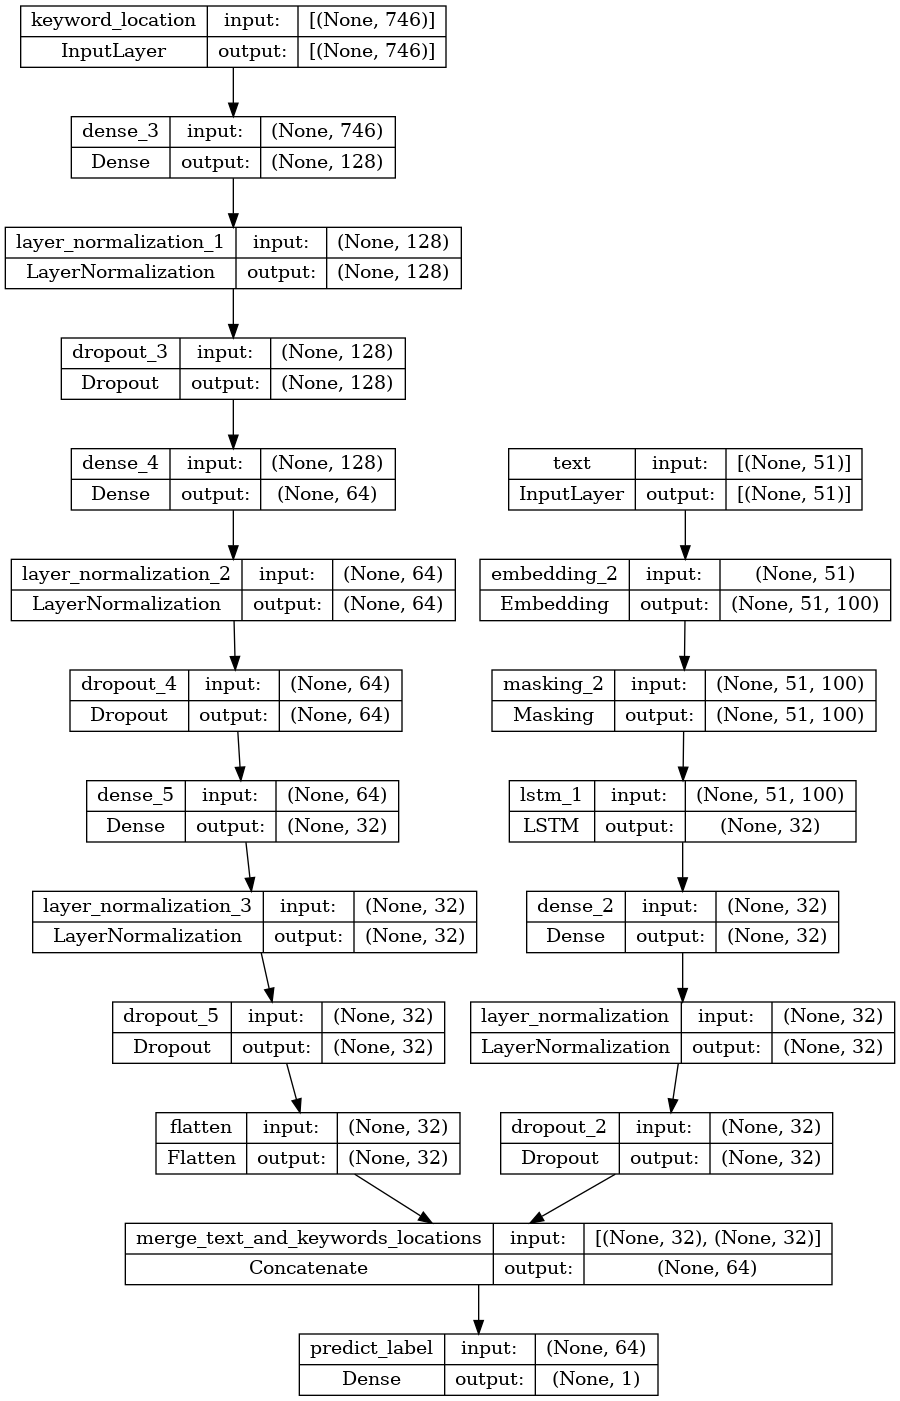

In [172]:
plot_model(rnn_model_func1, rnn_model_func1.name + ".png", show_shapes=True)

**Train model**

In [173]:
print('Training {} model on texts only...\n'.format(rnn_model_func1.name))
history = rnn_model_func1.fit(x={'text':X_train_rnn, 'keyword_location':X_train_rnn2_kl},  y = y_train_rnn, 
                    batch_size=64, epochs=50,
                    callbacks=callbacks,
                    validation_data=({'text':X_cv_rnn,'keyword_location': X_cv_rnn2_kl}, y_cv_rnn)
                             )
print('...Done')

Training RNN_text_plus_keyword_and_location model on texts only...

Epoch 1/50
96/96 [==============================] - 12s 54ms/step - loss: 0.7828 - accuracy: 0.5911 - val_loss: 0.5361 - val_accuracy: 0.7328
Epoch 2/50
96/96 [==============================] - 4s 37ms/step - loss: 0.5846 - accuracy: 0.7161 - val_loss: 0.6115 - val_accuracy: 0.6927
Epoch 3/50
96/96 [==============================] - 4s 39ms/step - loss: 0.5147 - accuracy: 0.7645 - val_loss: 0.4678 - val_accuracy: 0.7912
Epoch 4/50
96/96 [==============================] - 4s 39ms/step - loss: 0.4771 - accuracy: 0.7857 - val_loss: 0.4599 - val_accuracy: 0.7892
Epoch 5/50
96/96 [==============================] - 4s 37ms/step - loss: 0.4649 - accuracy: 0.7956 - val_loss: 0.4519 - val_accuracy: 0.7951
Epoch 6/50
96/96 [==============================] - 4s 37ms/step - loss: 0.4389 - accuracy: 0.8090 - val_loss: 0.4553 - val_accuracy: 0.7971
Epoch 7/50
96/96 [==============================] - 4s 38ms/step - loss: 0.4291 - acc

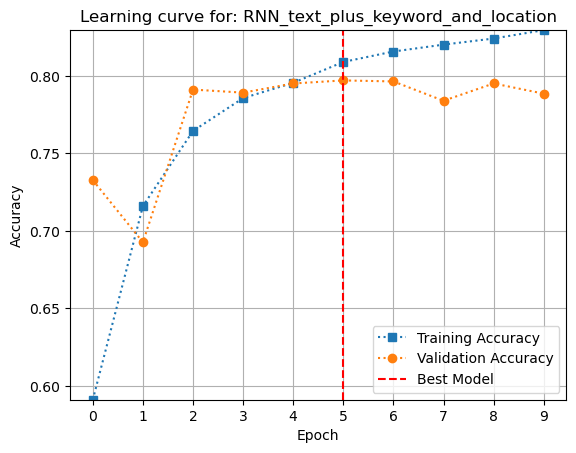

In [174]:
plot_learning_curves(history,rnn_model_func1.name)

In [175]:
# Reload best model
rnn_model_func1 = load_model(model_save_path)

Computing model predictions...
48/48 [==============================] - 2s 11ms/step
Cross validation accuracy of model `RNN_text_plus_keyword_and_location` is 79.51%


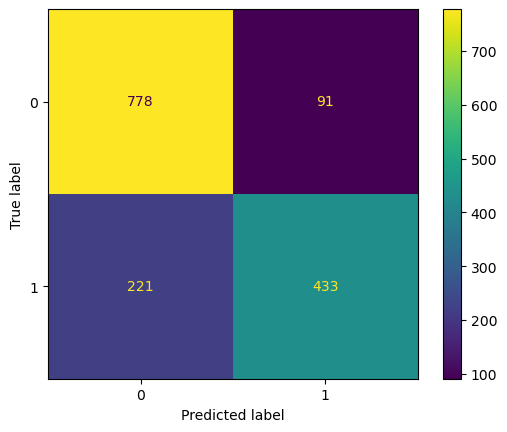

In [176]:
print('Computing model predictions...')
y_prob_cv = rnn_model_func1.predict({'text':X_cv_rnn,'keyword_location': X_cv_rnn2_kl})
y_pred_cv = np.round(y_prob_cv)
acc = display_conf_max_and_acc(y_cv,y_pred_cv,rnn_model_func1.name)

In [177]:
# Recursive neural network LSTM model using text only
model = {'model_name': rnn_model_func1.name,
    'cv_acc': acc,
        'model': rnn_model_func1}

models.append(model)
print("Model: {}\nCross Val accuracy: {:.2%}".format(model['model_name'],model['cv_acc']))

Model: RNN_text_plus_keyword_and_location
Cross Val accuracy: 79.51%


In [178]:
pd.DataFrame(models)

model_name    cv_acc  \
0          Baseline - Predict most frequent category  0.570584   
1  Gradient Boosting using keyword and location only  0.774130   
2                     RNN_single_LSTM_cell_only_text  0.798424   
3                               RNN_tuned_text_only2  0.804990   
4                 RNN_text_plus_keyword_and_location  0.795141   

                                               model  
0                                                NaN  
1  ([DecisionTreeRegressor(criterion='friedman_ms...  
2  <keras.engine.sequential.Sequential object at ...  
3  <keras.engine.sequential.Sequential object at ...  
4  <keras.engine.functional.Functional object at ...

## Discussion
* We are training on accuracy because the classes are balanced.
* Gradient boosting is able to reach around 73% accuracy using only keyword and location columns. Trees don't really need one hot encoding for categorical variables.
* Using the current word embedding, RNNs based on text only and GRU or LSTM cells can reach around 79% accuracy.  Keras tuner found better results with LSTM than with GRU cells.
* Using an RNN that can handle both text, keyword an location columns does not significantly increase accuracy. I tried other hyperparameter values but did not run keras tuner.

## Further work
* Maybe we could use data augmentation by concatenating tweets with same label.
* Using a different word embedding may prove useful as well. We could also train models from different word embedding and use bagging to increase accuracy.
* Use RNN as a feature extractor and pass it to gradient boosting with the location and keyword columns.

## Select best model

In [179]:
best_model_from_val_acc = max(models, key=lambda x: x['cv_acc'])
print("Best Model: {}\nCross Val accuracy: {:.2%}".format(best_model_from_val_acc['model_name'],best_model_from_val_acc['cv_acc']))

best_model = best_model_from_val_acc['model']

Best Model: RNN_tuned_text_only2
Cross Val accuracy: 80.50%


<a id='section5'></a>

# 5. Submit results

In [180]:
print('Computing submission file')
# Prepare submission file
df_submit = df_test.copy()

try:
    # Keras RNN text only
    df_submit['target'] = np.round(best_model.predict(X_test_rnn),0).astype(np.int64)

except:
    try:
        # Keras RNN text + keyword + location
        df_submit['target'] = np.round(best_model.predict({'text':X_test_rnn,'keyword_location': X_test_rnn2_kl}),0).astype(np.int64) 
    except:
        # Sklearn Gradient Boosting
        df_submit['target'] = np.round(best_model.predict(X_test_gb),0).astype(np.int64)
    
    
df_submit = df_submit.loc[:,['id','target']]
df_submit

Computing submission file
102/102 [==============================] - 1s 9ms/step


id  target
0         0       1
1         2       1
2         3       1
3         9       1
4        11       1
...     ...     ...
3258  10861       1
3259  10865       1
3260  10868       1
3261  10874       1
3262  10875       0

[3263 rows x 2 columns]

In [181]:
# Competition Submission
df_submit.to_csv('submission.csv', index=False)